# Predict Cancer Death Rate

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime



In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import math 

In [5]:
#Load Data
df_cancer = pd.read_csv('df_cancer.csv', encoding="ISO-8859-1")

### 5.1 Data Splitting, Imputation , Scaling and Encoding

In [6]:
X = df_cancer.drop(columns=['Deathrate', 'County', 'State'])
y = df_cancer.Deathrate

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42)

In [8]:
cat_bins = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

In [9]:
num_list = ['avgAnnCount', 'avgDeathsPerYear', 'incidenceRate', 'medIncome', 
            'popEst2015', 'povertyPercent', 'studyPerCap', 'MedianAge', 'MedianAgeMale', 
            'MedianAgeFemale', 'AvgHouseholdSize', 'PercentMarried', 'PctNoHS18_24', 'PctHS18_24', 
            'PctBachDeg18_24', 'PctHS25_Over', 'PctBachDeg25_Over', 'PctEmployed16_Over', 
            'PctUnemployed16_Over', 'PctPrivateCoverage', 'PctPrivateCoverageAlone', 'PctEmpPrivCoverage', 
            'PctPublicCoverage', 'PctPublicCoverageAlone', 'PctWhite', 'PctBlack', 'PctAsian', 'PctOtherRace', 
            'PctMarriedHouseholds', 'BirthRate']

In [10]:
blist = ['binnedInc']

In [11]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

Bin_transformer = Pipeline(steps=[
    ("ordinal_encoder", OrdinalEncoder(categories= [cat_bins]))])

#combine numeric and categorical pipelines
preprocess_pipe = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_list),
        ('bincat', Bin_transformer, blist)])


In [12]:

# fit the pipelines to the training data
preprocess_pipe.fit_transform(X_train)

# apply the pipelines to the training and test data
X_train = preprocess_pipe.transform(X_train)
X_test = preprocess_pipe.transform(X_test)

In [13]:
X_train = pd.DataFrame(X_train, columns = (num_list+blist))

In [14]:
X_test = pd.DataFrame(X_test, columns = (num_list+blist))

### 5.2 Load Model

In [15]:
import xgboost as xgb
from xgboost import XGBRegressor

In [16]:
bst_model = pickle.load(open('cancer_deathrate.sav', 'rb'))

### 5.3 Model Metrics

### R-squared

In [27]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
xgb_r2 = cross_validate(bst_model, X_train, y_train, 
                            scoring='r2', cv=5, n_jobs=-1)

In [28]:
xgb_r2_mean = np.mean(xgb_r2['test_score'])
xgb_r2_std = np.std(xgb_r2['test_score'])
xgb_r2_mean, xgb_r2_std

(0.6833475148150081, 0.020565188096884002)

### MAE

In [19]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
xgb_neg_mae = cross_validate(bst_model, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [20]:
xgb_mae_mean = np.mean(-1 * xgb_neg_mae['test_score'])
xgb_mae_std = np.std(-1 * xgb_neg_mae['test_score'])
xgb_mae_mean, xgb_mae_std

(11.354562736097094, 0.46471242217060943)

In [21]:
mean_absolute_error(y_test, bst_model.predict(X_test))

11.079733825016543

### MSE

In [23]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
xgb_neg_mse = cross_validate(bst_model, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

In [24]:
xgb_mse_mean = np.mean(-1 * xgb_neg_mse['test_score'])
xgb_mse_std = np.std(-1 * xgb_neg_mse['test_score'])
xgb_mse_mean, xgb_mse_std

(237.02598849225416, 26.947580389003303)

### RMSE

In [29]:
rmse_mean = (xgb_mse_mean)**(1/2.0)
rmse_std = (xgb_mse_std)**(1/2.0)
rmse_mean, rmse_std

(15.395648362191642, 5.191105892678679)

### TEST METRICS

In [35]:
y_te_pred =bst_model.predict(X_test)

In [36]:
r2_score(y_test, y_te_pred)

0.6984209603007427

In [37]:
mean_absolute_error(y_test, y_te_pred)

11.079733825016543

In [38]:
mean_squared_error(y_test, y_te_pred)

245.39792127421674

### 5.4 Feature Importance

In [17]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
from matplotlib import pyplot

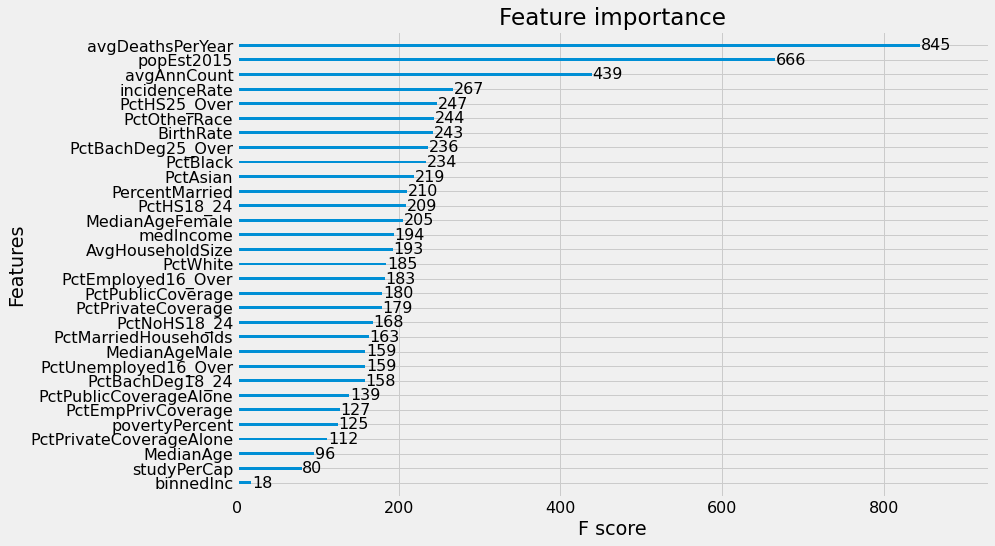

In [30]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

plt.rcParams["figure.figsize"] = (12,8) 
plot_importance(bst_model)
plt.show();